In [21]:
import requests
from bs4 import BeautifulSoup
import time

In [22]:
now = str(int(time.time()))
now

'1717437144'

In [23]:
url = 'https://finance.yahoo.com/quote/BTC-USD/history/?period1=1585872000&period2=' + now
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}
response = requests.get(url,headers=headers)
print(response)

<Response [200]>


In [24]:
soup = BeautifulSoup(response.text,'html.parser')
soup.title.text

'Bitcoin USD (BTC-USD) Stock Historical Prices & Data - Yahoo Finance'

In [25]:
print(soup.prettify()[:500])

<!DOCTYPE html>
<html class="desktop neo-green" data-color-scheme="light" lang="en-US" theme="light">
 <head>
  <meta charset="utf-8"/>
  <meta content="width=device-width, initial-scale=1" name="viewport"/>
  <meta content="guce.yahoo.com" name="oath:guce:consent-host"/>
  <link href="/manifest.json" rel="manifest"/>
  <link href="../../../assets/_app/immutable/assets/2.CY4SIFrD.css" rel="stylesheet"/>
  <link href="../../../assets/_app/immutable/assets/Ads.3RMLh2mX.css" rel="stylesheet"/>
  <l


In [26]:
records = soup.find_all('tr', class_='svelte-ewueuo')
records[:5]

[<tr class="svelte-ewueuo"><th class="svelte-ewueuo">Date  </th><th class="svelte-ewueuo">Open  </th><th class="svelte-ewueuo">High  </th><th class="svelte-ewueuo">Low  </th><th class="svelte-ewueuo">Close   <span class="container svelte-7dju6j"><div class="icon fin-icon primary-icn sz-medium tw-align-text-top svelte-21xhfv"><!-- HTML_TAG_START --><svg viewbox="0 0 24 24" xmlns="http://www.w3.org/2000/svg"><path d="M11 7h2v2h-2zm0 4h2v6h-2zm1-9C6.48 2 2 6.48 2 12s4.48 10 10 10 10-4.48 10-10S17.52 2 12 2m0 18c-4.41 0-8-3.59-8-8s3.59-8 8-8 8 3.59 8 8-3.59 8-8 8"></path></svg><!-- HTML_TAG_END --></div> <div class="tooltip al-bottom svelte-7dju6j" role="tooltip"><div class="arrow svelte-7dju6j"></div> <h3 class="title svelte-7dju6j"></h3> <span class="toolTipContent svelte-ewueuo" slot="content">Close price adjusted for splits. </span></div> </span> </th><th class="svelte-ewueuo">Adj Close   <span class="container svelte-7dju6j"><div class="icon fin-icon primary-icn sz-medium tw-align-tex

In [27]:
print('total records count: ', len(records))
print('data of %.2f years' % (len(records)/365))

total records count:  1524
data of 4.18 years


In [28]:
date = []
price = []

for rec in records[1:]:
    tds = rec.find_all('td')
    date.append(tds[0].text)
    price.append(tds[4].text)

In [29]:
import numpy as np
import pandas as pd

In [30]:
df = pd.DataFrame({'date':date, 'price':price})
df.head()

,date,price
0,"Jun 3, 2024","69,250.91"
1,"Jun 2, 2024","67,751.60"
2,"Jun 1, 2024","67,706.94"
3,"May 31, 2024","67,491.41"
4,"May 30, 2024","68,364.99"


In [31]:
df['price'] = df['price'].str.replace(',', '').astype(float)

In [32]:
df['date'] = pd.to_datetime(df['date'], format='%b %d, %Y')
df.set_index('date', inplace=True)

In [33]:
df.head()

,price
date,
2024-06-03,69250.91
2024-06-02,67751.60
2024-06-01,67706.94
2024-05-31,67491.41
2024-05-30,68364.99


In [34]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['price'].values.reshape(-1, 1))

In [35]:
scaled_data

array([[0.94231623],
       [0.91975032],
       [0.91907815],
       ...,
       [0.00224288],
       [0.00339276],
       [0.00137384]])

In [36]:
time_step = 10
X, Y = [], []

for i in range(len(scaled_data) - time_step - 1):
    X.append(scaled_data[i:(i + time_step), 0])
    Y.append(scaled_data[i + time_step, 0])
    
X, Y = np.array(X), np.array(Y)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [37]:
print('data of previous 7 days :\n',X[0])
print('\nlabel (btc price of that day) :\n',Y[0])

data of previous 7 days :
 [[0.94231623]
 [0.91975032]
 [0.91907815]
 [0.91583424]
 [0.92898237]
 [0.91713885]
 [0.92794732]
 [0.94447813]
 [0.93128666]
 [0.94254259]]

label (btc price of that day) :
 0.9314072146895183


In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(Input(shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
hist = model.fit(X, Y, batch_size=32, epochs=50)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0740
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013 
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012
Epoch 10/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014
Epoch 11/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013 
Epoch 12/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014 
Epoch 13/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013
Epoch 14/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.5877e-04
Epoch 15/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 
Epoch 16/50

In [45]:
train_predict = model.predict(X)
train_predict = scaler.inverse_transform(train_predict)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


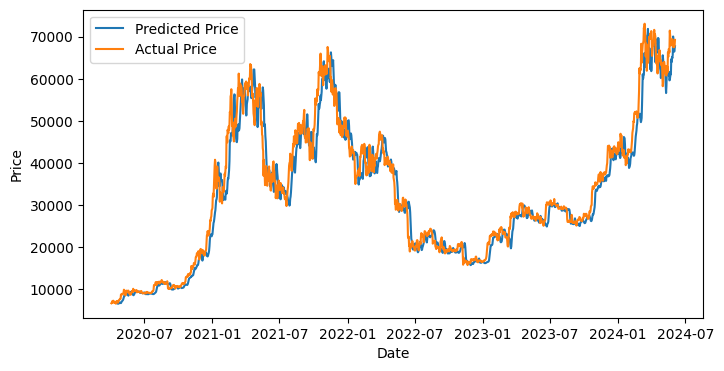

In [46]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot(df.index[:len(train_predict)], train_predict, label='Predicted Price')
plt.plot(df.index, df['price'], label='Actual Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [47]:
tomorrow_pred = model.predict(X[[0]])
price = scaler.inverse_transform(tomorrow_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [49]:
print('predicted bitcoin price for tomorrow: %.3f' % float(price.squeeze()))

predicted bitcoin price for tomorrow: 67749.242
